# 2019 2nd ML month with KaKR

In [1]:
##################################
### Install required libraries ###
##################################
! pip install xgboost lightgbm missingno scikit-learn
! pip install seaborn==0.11.1 # colab의 sns버전이 0.11.2 이므로 sns.kdeplot 시 에러 발생

     |████████████████████████████████| 285 kB 6.7 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [2]:
#################################
### Import required libraries ###
#################################
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

#################
### Data path ###
#################
data_dir = r'/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)
print('==========================================================')

#####################
### Read csv file ###
#####################
data = pd.read_csv(train_data_path)
orig_data = data.copy()
sub = pd.read_csv(sub_data_path)
orig_sub = sub.copy()
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))
# 테스트 데이터에는 우리가 예측할 price 컬럼이 빠짐
print('==========================================================')

#######################################################
### Delete column that do not require preprocessing ###
#######################################################
y = data['price']
del data['price']

print(data.columns)
print('==========================================================')

##########################################
### Concatenate data (training + test) ###
##########################################
train_len = len(data)
data = pd.concat((data, sub), axis=0)
orig_data = pd.concat((orig_data, orig_sub), axis=0)

print(len(data))
data.head()

/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/train.csv
/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/test.csv
train data dim : (15035, 21)
sub data dim : (6468, 20)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


Data configuration

    1. id : 집을 구분하는 번호
    2. date : 집을 구매한 날짜
    3. price : 타겟 변수인 집의 가격
    4. bedrooms : 침실의 수
    5. bathrooms : 침실당 화장실 개수
    6. sqft_living : 주거 공간의 평방 피트
    7. sqft_lot : 부지의 평방 피트
    8. floors : 집의 층수
    9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    10. view : 집이 얼마나 좋아 보이는지의 정도
    11. condition : 집의 전반적인 상태
    12. grade : King County grading 시스템 기준으로 매긴 집의 등급
    13. sqft_above : 지하실을 제외한 평방 피트
    14. sqft_basement : 지하실의 평방 피트
    15. yr_built : 집을 지은 년도
    16. yr_renovated : 집을 재건축한 년도
    17. zipcode : 우편번호
    18. lat : 위도
    19. long : 경도
    20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

- 우선 데이터 전처리 전에 유심해서 살펴볼 데이터가 뭘까?
    - 만약 진짜 내가 집을 구한다고 생각해 봤을 때 가장 중요하게 볼 요소들을 골라보자
    - `bedrooms`, `sqft_living`, `condition`, `grade`, `yr_built`, `yr_renovated`, `sqft_living15`
    - 모든 데이터를 확인해 볼 수도 있지만, 일단 위의 데이터만 가지고 price와의 관계 간단하게 확인

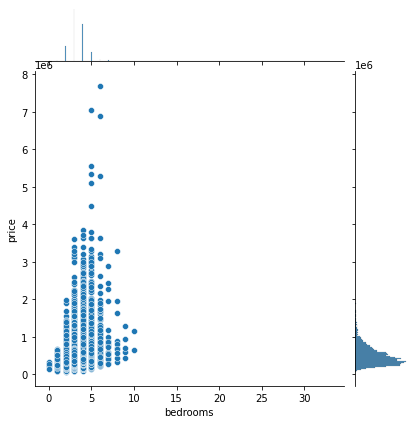

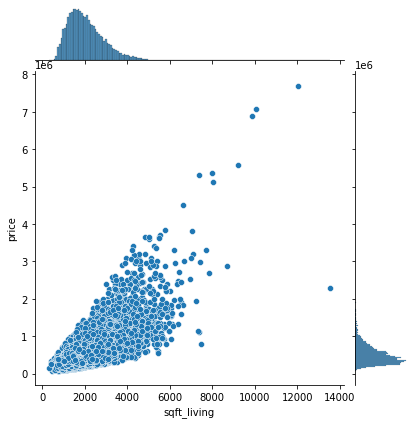

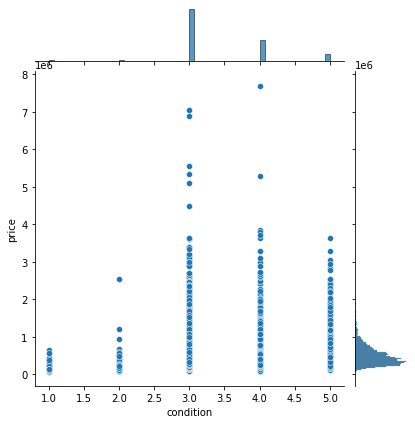

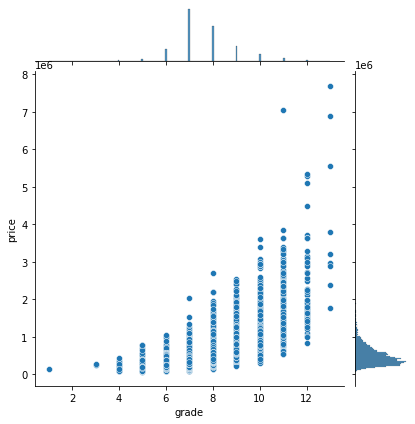

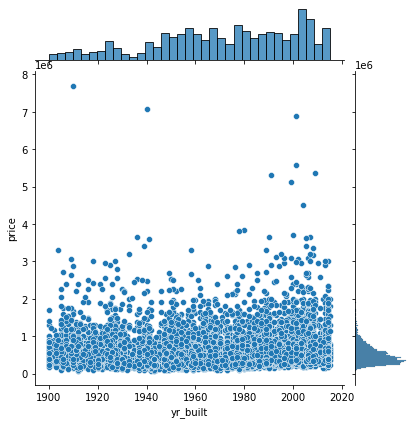

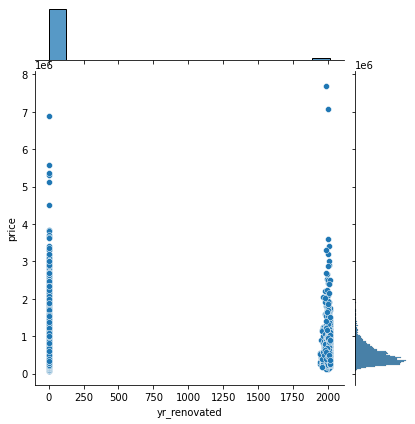

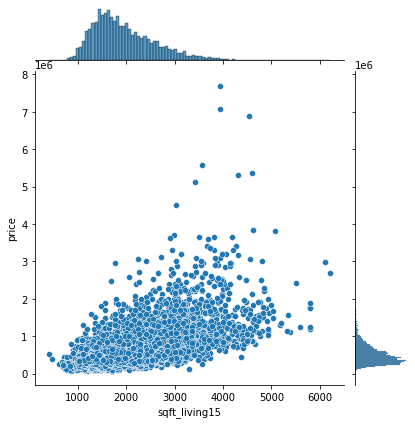

In [3]:
data_to_check_lst = ['bedrooms', 'sqft_living', 'condition', 'grade', 'yr_built', 'yr_renovated', 'sqft_living15']
data_to_check_num = len(data_to_check_lst)

for i in range(data_to_check_num):
    sns.jointplot(x=data_to_check_lst[i], y="price", data=orig_data, kind='scatter')

## 데이터 전처리

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


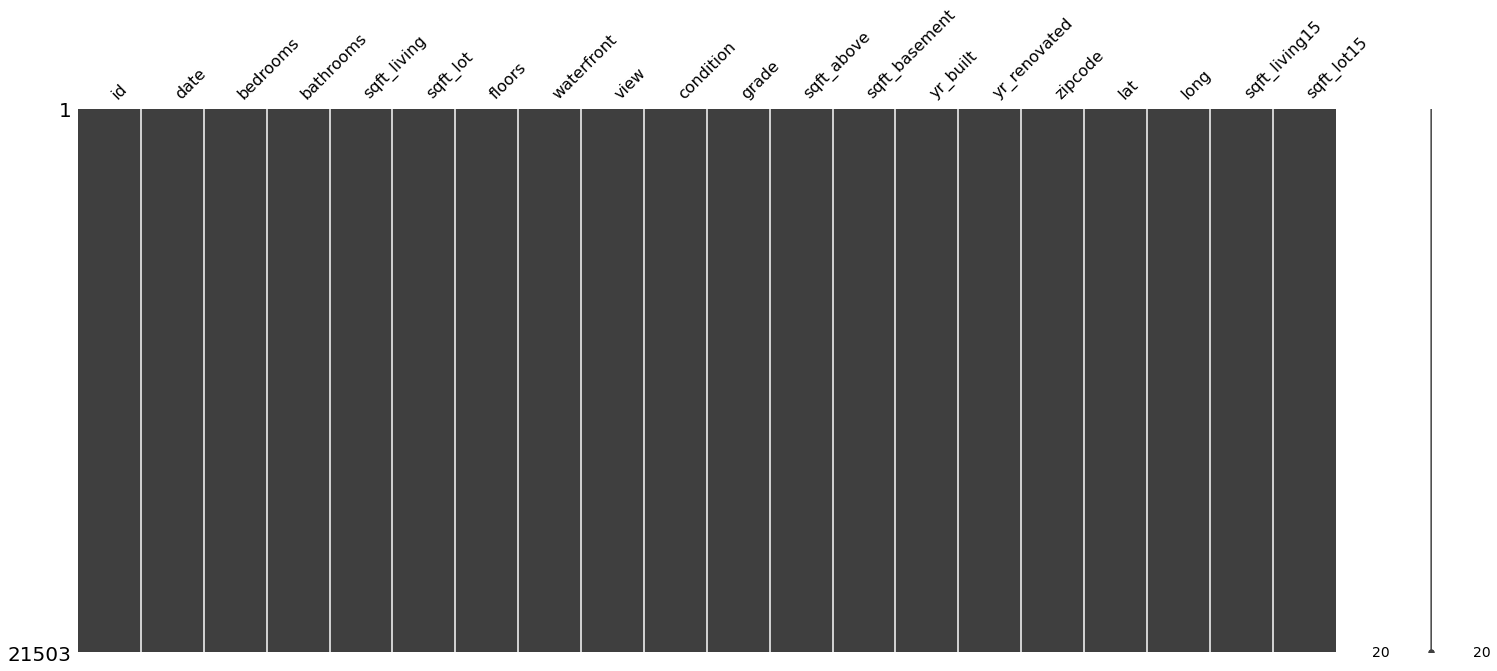

In [4]:
#################
### Check NaN ###
#################
msno.matrix(data) # visualization using missiongno

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
print('==========================================================')

###############################
### Preprocessing: id, date ###
###############################
sub_id = data['id'][train_len:] 
# test data에서 필요없는 id 컬럼 제거 및 sub_id 에 저장
del data['id']

print(data.columns)

# date: 20141013T000000 -> 201410
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

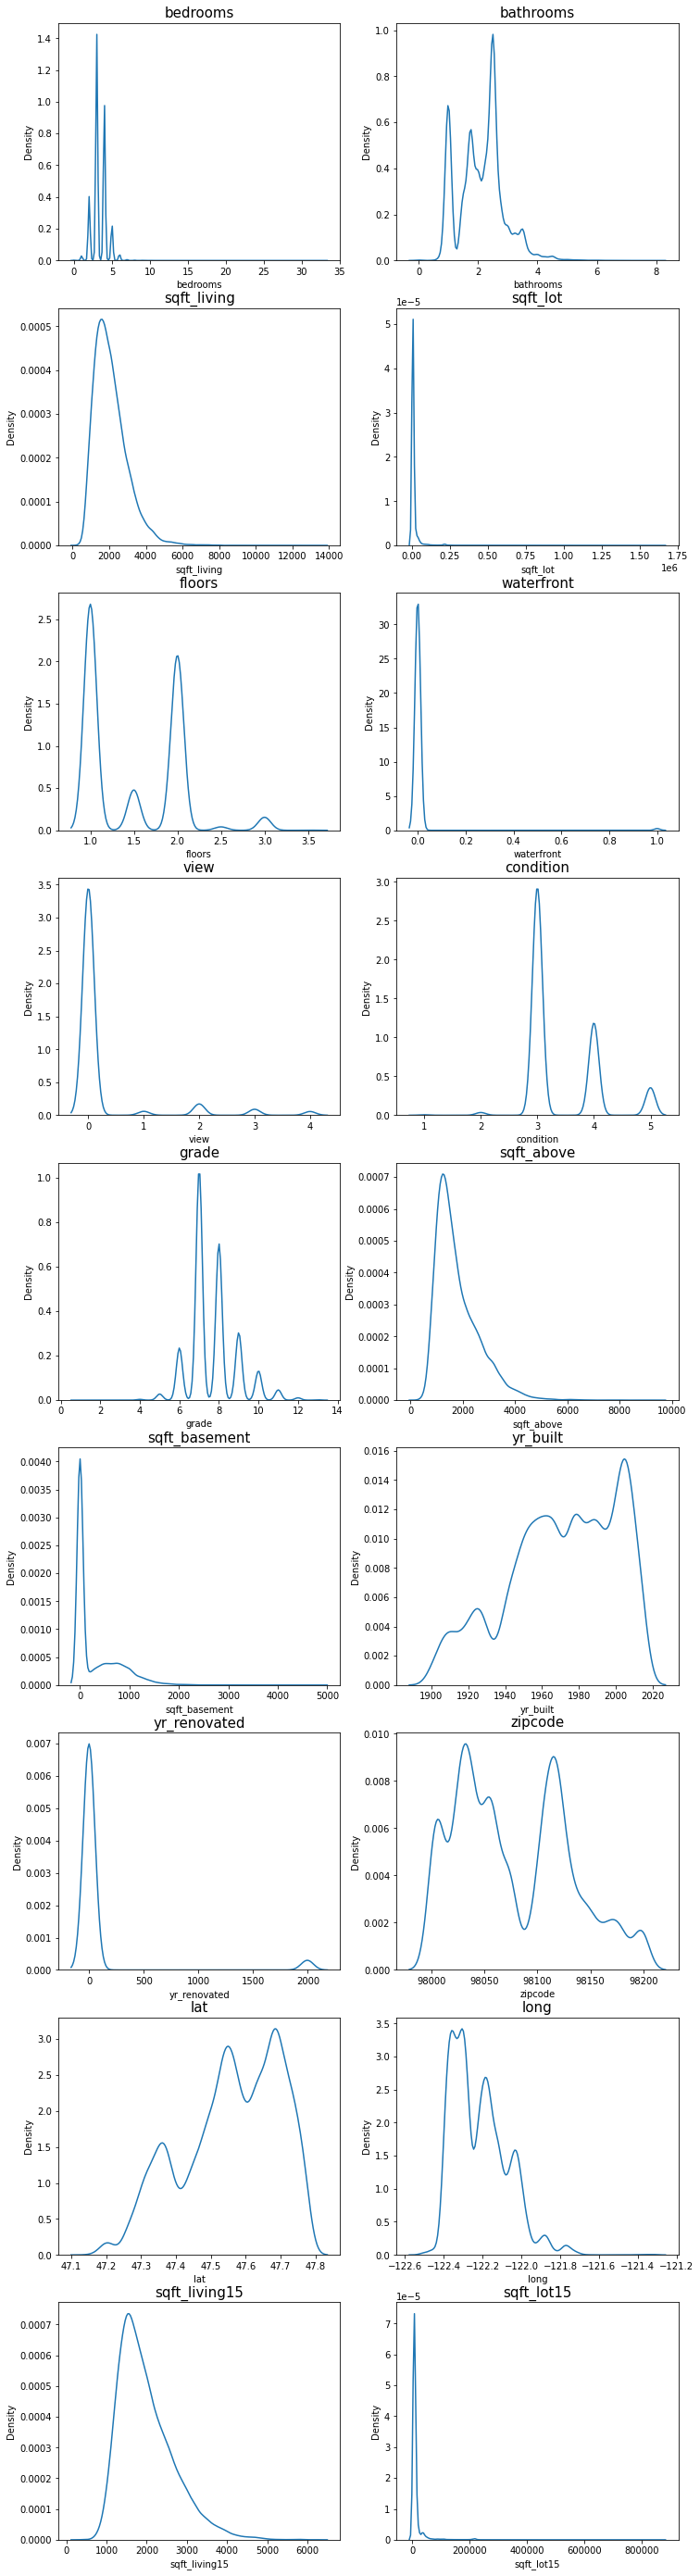

In [5]:
################################
### Check data distributions ###
################################
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# sns.kdeplot을 활용하여 id 제외하고 치우친 데이터 분포 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

데이터 분포를 정규분포에 가깝게 만들었습니다. 아래 결과를 확인하세요.


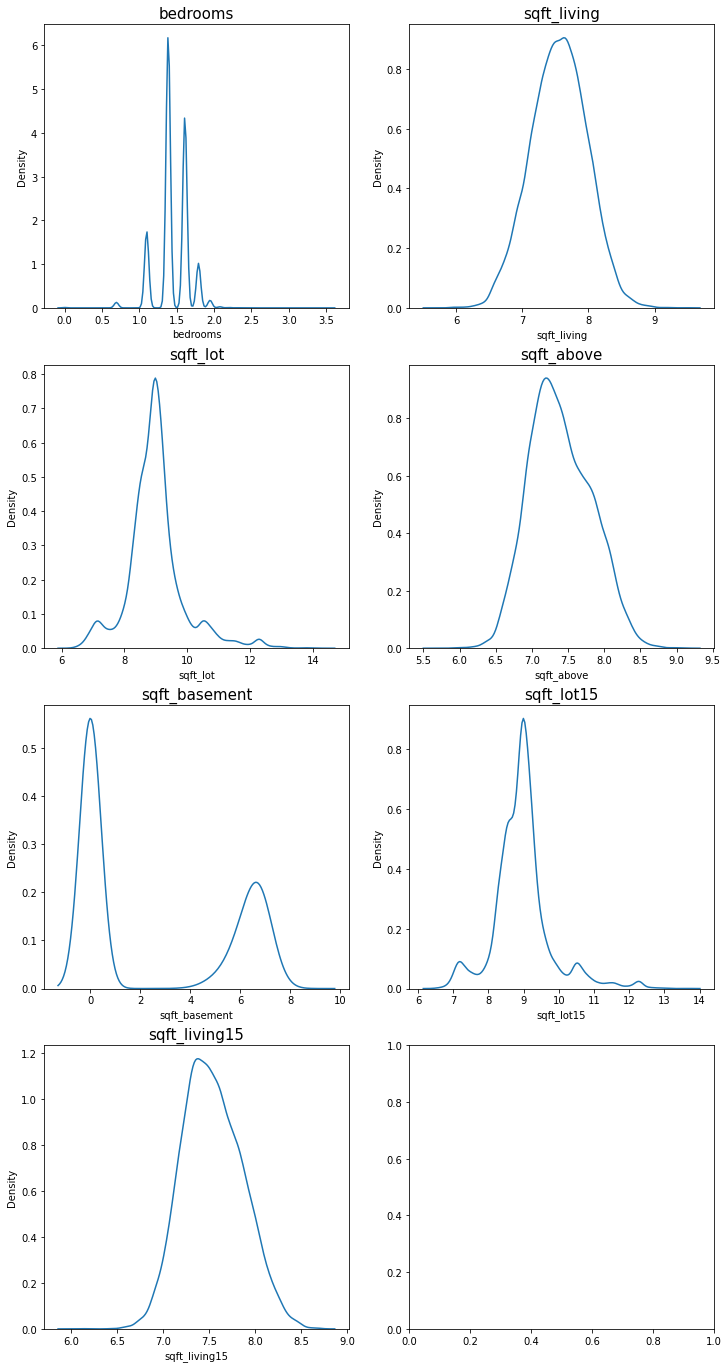

In [6]:
###########################
### Feature engineering ###
###########################
"""
log-scaling 을 활용한 정규분포화 using numpy.log1p()
"""
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('데이터 분포를 정규분포에 가깝게 만들었습니다. 아래 결과를 확인하세요.')

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

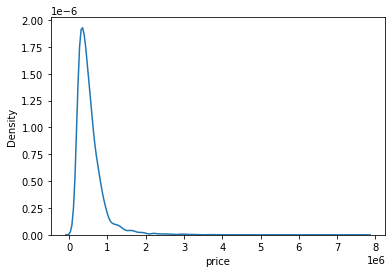

price 데이터 분포를 정규분포에 가깝게 만들었습니다. 아래 결과를 확인하세요.


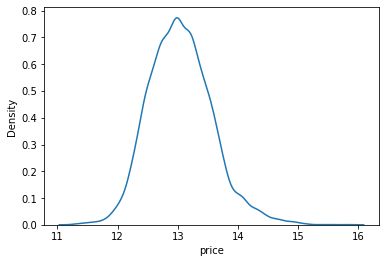

(15035, 19)
(6468, 19)


In [7]:
###########################
### Feature engineering ###
###########################
# 위와 동일하게 price도 log-scaling 적용
sns.kdeplot(y)
plt.show()

y_log_transformation = np.log1p(y)
print('price 데이터 분포를 정규분포에 가깝게 만들었습니다. 아래 결과를 확인하세요.')

sns.kdeplot(y_log_transformation)
plt.show()
print('==========================================================')

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

- 데이터를 깊게 탐색하는 EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제
- 피처 엔지니어링: 기존에 있는 데이터의 피처 모델을 보다 잘 표현할 수 있는 형태로 처리

## 모델 학습

- Blending (=Ensemble) 이란?
    - 블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법
    - 앙상블 기법 중 가장 기본적인 것은 보팅(Voting)과 에버리징(Averaging)
        - Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용
        - Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용


In [8]:
# 데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split
# RMSE 점수를 계산하기 위한 mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#################
### Read data ###
#################
data_dir = r'/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#####################
### Preprocessing ###
#####################
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']
del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

y = np.log1p(y)

# 단, 평가 척도인 RMSE를 계산하기 전에 주의해야 할 것은,
# y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 
# 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 함

# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하자
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

################
### Modeling ###
################
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현 가능
# 하지만 값을 지정하지 않고 None으로 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 
# 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 
# 머신러닝 학습결과는 학습할 때마다 달라짐

#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2022        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print(gboost.__class__.__name__) # 각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻을 수 있음

# 위의 과정을 get_scores(models, train, y) 함수로 만들어 보자
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df
    
get_scores(models, train, y)

GradientBoostingRegressor
[14:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
RandomForestRegressor,136410.843812
XGBRegressor,132088.019304
GradientBoostingRegressor,130361.233685
LGBMRegressor,120099.067237


## 예측

### Average Blending

- 여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들어 보자
    - 여러 모델에 대해서 예측 결과를 평균내어 사용
    - 아래의 `AveragingBlending()` 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습한 뒤, `predictions`에 그 예측 결괏값을 모아서 평균한 값을 반환
- 모델은 부스팅 계열인 `gboost`, `xgboost`, `lightgbm` 세 가지를 사용

In [9]:
########################
### Average Blending ###
########################
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 함수를 활용해서 예측값을 생성해 보자!
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[14:12:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([13.18401874, 12.90543178, 14.10058161, ..., 12.99471944,
       12.73230418, 12.94712743])

In [10]:
#######################
### Submission file ###
#######################
data_dir = r'/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data'

result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/submission.csv


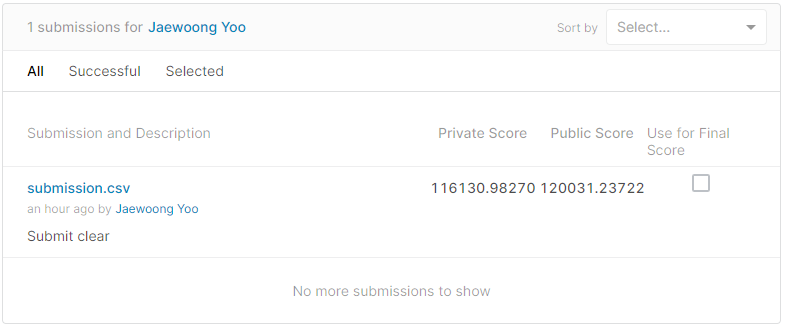

## 최적화 진행

- 하이퍼 파라미터 튜닝 (1)
    - 그리드 탐색을 시도해서 최적의 조합 찾기
        - 그리드 탐색이란?
            - 그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색
            - 따라서 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리
        - 랜덤 탐색이란?
            - 랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
        - 그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면, 랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있음
        - 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없음

`GridSearchCV`에 입력되는 인자들    

    param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    scoring : 모델의 성능을 평가할 지표
    cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


In [11]:
from sklearn.model_selection import GridSearchCV

###################
### Grid Search ###
###################
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 15],
    'learning_rate': [0.1, 0.01],
    'boosting': ['rf', 'gbdt', 'dart', 'goss']
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:   56.1s finished


,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
23,gbdt,0.10,10,200,-0.026188,0.161828
26,gbdt,0.10,15,200,-0.026364,0.162371
22,gbdt,0.10,10,100,-0.027027,0.164399
25,gbdt,0.10,15,100,-0.027174,0.164845
24,gbdt,0.10,15,50,-0.029170,0.170792
...,...,...,...,...,...,...
13,rf,0.01,10,100,NaN,NaN
14,rf,0.01,10,200,NaN,NaN
15,rf,0.01,15,50,NaN,NaN
16,rf,0.01,15,100,NaN,NaN


- 위에서 사용한 LGBMRegressor 말고도 XGBRegressor, RandomForestRegressor과 같은 다양한 모델에 대해 하이퍼 파라미터 튜닝 해보자

In [15]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 15],
    'eta': [0.1],
    'booster': ['gblinear', 'gbtree']  # 'dart'는 학습 시간이 너무 오래걸려 제외
}

xgboost = XGBRegressor(random_state=random_state)
my_GridSearch(xgboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:  1.2min finished


[14:32:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,booster,eta,max_depth,n_estimators,score,RMSLE
14,gbtree,0.1,10,200,-0.026859,0.163887
13,gbtree,0.1,10,100,-0.027051,0.164472
17,gbtree,0.1,15,200,-0.028308,0.168251
16,gbtree,0.1,15,100,-0.028357,0.168395
12,gbtree,0.1,10,50,-0.034190,0.184906
15,gbtree,0.1,15,50,-0.034989,0.187053
11,gbtree,0.1,1,200,-0.045150,0.212486
10,gbtree,0.1,1,100,-0.054988,0.234496
9,gbtree,0.1,1,50,-0.077518,0.278421
8,gblinear,0.1,15,200,-0.115479,0.339822


In [17]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = r'/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 위에서 가장 좋은 조합(max_depth=10, n_estimators=200, learning_rate=0.1, boosting = 'gbdt')의 파라미터를 가진 모델로 학습 후 예측 결과 생성
lightgbm = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, boosting='gbdt', random_state=random_state)
save_submission(lightgbm, train, y, test, 'lgbm', rmsle='0.161828')

/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161828.csv saved!


In [19]:
# 위에서 가장 좋은 조합(max_depth=10, n_estimators=200, eta=0.1, booster='gbtree')의 파라미터를 가진 모델로 학습 후 예측 결과 생성
xgboost = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, booster='gbtree', random_state=random_state)
save_submission(xgboost, train, y, test, 'xgb', rmsle='0.163887')

[14:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.163887.csv saved!


- Baseline 커널에서 활용했던 블렌딩 방법 적용하기
- 위에서 만든 `AveragingBlending()` 적용

In [26]:
# lightgbm = LGBMRegressor(random_state=random_state)
# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [{'model':lightgbm, 'name':'LightGBM'}, {'model':gboost, 'name':'GradientBoosting'}, 
#           {'model':xgboost, 'name':'XGBoost'}, {'model':rdforest, 'name':'RandomForest'},]
lightgbm = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, boosting='gbdt', random_state=random_state)
xgboost = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, booster='gbtree', random_state=random_state)
models = [{'model':lightgbm, 'name':'LightGBM'}, {'model':xgboost, 'name':'XGBoost'}]

########################
### Average Blending ###
########################
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 함수를 활용해서 예측값을 생성해 보자!
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred = np.expm1(y_pred)

[14:55:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


In [27]:
#######################
### Submission file ###
#######################
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/AIFFEL/Exploration/kaggle_kakr_housing/data/submission.csv


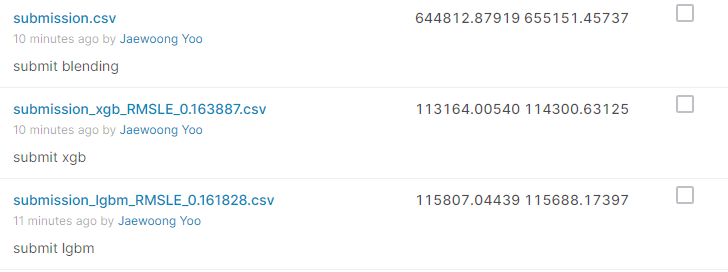

## 결론

- log-scaling 을 활용한 정규분포화 및 특정 데이터의 전처리를 진행하였으며, 다양한 모델학습과 예측 과정을 거쳐 캐글 submission까지 진행됨
- 전처리, 학습, 최적화의 각 진행 과정 및 방법에 대해서 설명함
- 하이퍼 파라미터 튜닝 시 `learning_rate`는 0에 가까워질 수록 성능이 계속 낮아짐을 보여 learning rate는 [0.1, 0.01] 사이로 조정하였으며, XGBRegressor에서는 학습 시간이 오래걸려 lr=0.1로만 진행
- boosting 방법으로 LGBMRegressor 모델에서는 rf(랜덤포레스트)로 부스팅 적용시 점수 계산이 되지 않는 것을 확인
- 각 모델별로 최적화를 통해 최적화 parameter를 도출하였으며, `LGBMRegressor`, `GradientBoostingRegressor`, `XGBRegressor`, `RandomForestRegressor` 모델에 대한 블렌딩 기법을 활용하여 Private score 기준 110000 이하의 점수를 얻을 수 있었음